In this notebook we implement the stage 1 of the phononet architecture in tensorflow. We use the phononet library to just extract the chromogram data.

In [1]:
import matplotlib.pyplot as plt
import json
from collections import Counter

%matplotlib inline

import sys
import os

%load_ext autoreload
%autoreload 2


In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [3]:
sys.path.append('../')

In [4]:
import phononet as pn
import utils

In [5]:
include_files = json.load(open('SankalpRagaDataset.json'))  # import list of song_ids to include
cd = pn.FullChromaDataset('hindustaniv2.json', '../../n_ftt4096__hop_length2048',
                          include_mbids=include_files)  # load dataset of "full song" chromagrams
train, test = cd.train_test_split(train_size=0.75)  # split training and test sets from "full song" chromagrams
train = pn.ChromaChunkDataset(train, chunk_size=1500)  # divide training set into chunks of width 150
test = pn.ChromaChunkDataset(test, chunk_size=1500)

Loading Chromagram Files: 100%|██████████| 300/300 [00:01<00:00, 183.19it/s]


In [6]:
#raga_detector = pn.RagaDetector(batch_size=32, gpus=1)
#raga_detector.fit(train, test)

In [7]:
X_train=train.X.numpy()
y_train=np.array(train.y).astype(np.int8)

X_val=test.X.numpy()
y_val=np.array(test.y).astype(np.int8)

<BarContainer object of 30 artists>

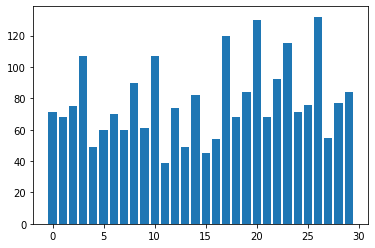

In [8]:
a,b=zip(*sorted(Counter(y_train).items(),key=lambda x:x[0]))
plt.bar(a,b)

In [9]:
from collections import Counter
counter=Counter(y_train)
weights=np.array([1/counter[val] for val in y_train])
weights/=weights.sum()
idxs=np.random.choice(range(len(y_train)),len(y_train),p=weights)

<BarContainer object of 30 artists>

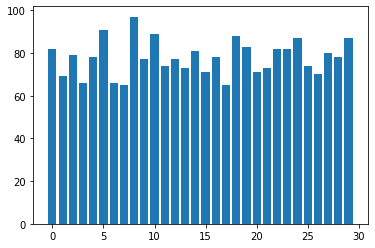

In [10]:
a,b=zip(*sorted(Counter(y_train[idxs]).items(),key=lambda x:x[0]))
plt.bar(a,b)

In [11]:
def gen(X,y,augment,balanced):
    n=len(X)
    
    if balanced:
        counter=Counter(y)
        weights=np.array([1/counter[val] for val in y])
        weights/=weights.sum()
        idxs=np.random.choice(range(n),n,p=weights)
    else:
        idxs=list(range(n))
        
    offsets=np.random.randint(12,size=n)
    np.random.shuffle(idxs)
    
    l=list(range(12))
    
    ls=[]
    for i in range(12):
        ls.append(l[i:]+l[:i])
    
    for idx,i in zip(idxs,offsets):
        if augment:
            yield X[idx].take(ls[i],axis=0),y[idx]
        else:
            yield X[idx],y[idx]




In [12]:
BATCH_SIZE=32
AUGMENT=True
BALANCED=True
train_data=tf.data.Dataset.from_generator(generator=gen,args=(X_train,y_train,AUGMENT,BALANCED),
                                           output_shapes=(tf.TensorShape([12,1500]),tf.TensorShape([])),
                                           output_types=(tf.float32,tf.int8)
                                          ).repeat().batch(BATCH_SIZE)
val_data=tf.data.Dataset.from_tensor_slices((X_val,y_val)).shuffle(1000).batch(BATCH_SIZE)

In [13]:
from tensorflow.keras.layers import Conv2D
from utils import MySequential, ConfusionMatrixMetric, PeriodicPaddingConv2D

In [14]:
ConvLayer=Conv2D

In [15]:
class ConvBlock(keras.layers.Layer):
    
    def __init__(self,*args,**kwargs):
        name=kwargs.pop('name',None)
        super().__init__(name=name)
        self.max_pool=kwargs.pop('max_pool',None)
        self.dropout=kwargs.pop('dropout',None)
        self.zero_padding=kwargs.pop('zero_padding',None)
        self.args=args
        self.kwargs=kwargs
        
        
    def build(self,input_shape):
        layers=[tf.keras.layers.Input(shape=input_shape[1:])]
        if self.zero_padding is not None:
            layers.append(tf.keras.layers.ZeroPadding2D(padding=self.zero_padding))
        layers.extend([
            ConvLayer(*self.args,**self.kwargs),
            keras.layers.LeakyReLU(alpha=leaky_relu_parameter),
            keras.layers.BatchNormalization(axis=[3]), # batch normalization on everything but last dimension
        ])
        if self.max_pool is not None:
            layers.append(keras.layers.MaxPool2D(self.max_pool))
        if self.dropout is not None:
            layers.append(keras.layers.Dropout(self.dropout))
        self.model=keras.Sequential(layers)
        
    def call(self,x):
        return self.model(x)

In [16]:
from tensorflow.keras import Sequential

In [17]:

class Inception1D(keras.layers.Layer):
    
    def __init__(self, scales):
        super().__init__()
        self.scales=scales
    
    def build(self, input_shape):
        inp=keras.layers.Input(shape=(input_shape[1],input_shape[2]))
        paths=[tf.keras.layers.Conv1D(1,1,padding='same')(inp)]
        for scale in self.scales:
            _path=tf.keras.layers.Conv1D(1,1,padding='same')(inp)
            paths.append(tf.keras.layers.Conv1D(1,scale,padding='same')(inp))
        concat=tf.concat(paths,-1)
        self.model=keras.Model(inputs=[inp],outputs=[concat])
        
    def call(self,x):
        return self.model(x)


In [18]:
class OnlyTimeConvolution(tf.keras.layers.Layer):
    
    def __init__(self,scales,*args,**kwargs):
        name=kwargs.pop('name',None)
        super().__init__(name=name)
        self.tr1=keras.layers.Lambda(lambda x: tf.transpose(x,[0,2,1,3]))
        self.tr2=keras.layers.Lambda(lambda x: tf.transpose(x,[0,2,1,3]))
        self.inception=Inception1D(scales)
    
    def build(self,input_shape):
        self.num_channels=input_shape[1]
        
    def call(self,x):
        
        x=self.tr1(x)
        x=tf.stack([self.inception(x[:,:,i]) for i in range(self.num_channels)],2)
        x=self.tr2(x)
        return x

In [19]:
120/1500*100

8.0

In [20]:
initial_time_only_conv=Sequential([
    OnlyTimeConvolution(scales=(20,40,60,100)),
    keras.layers.MaxPool2D((1,10)),
    Conv2D(1,(1,1),padding='same'),
    #
],name='initial_time_only_conv_encoder')
model=tf.keras.Sequential([
    keras.layers.Input(shape=(12,1500)),
    keras.layers.Lambda(lambda x: tf.expand_dims(x,-1),name='expand_dims'),
    initial_time_only_conv
]).summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
expand_dims (Lambda)         (None, 12, 1500, 1)       0         
_________________________________________________________________
initial_time_only_conv_encod (None, 12, 150, 1)        232       
Total params: 232
Trainable params: 232
Non-trainable params: 0
_________________________________________________________________


In [21]:
dropout_prob=0.3
PADDING_TYPE='valid'
kernel_initializer='he_uniform'
leaky_relu_parameter=1e-2

model=MySequential([
    keras.layers.Input(shape=(12,1500)),
    keras.layers.Lambda(lambda x: tf.expand_dims(x,-1),name='expand_dims'),
    keras.layers.BatchNormalization(axis=[3],name='norm0'),
    #
    initial_time_only_conv,
    #
    ConvBlock(64,(3,3),
              name='conv_block_1',
              zero_padding=(0,1),
              padding=PADDING_TYPE,
              kernel_initializer=kernel_initializer,
              max_pool=(1,2),
              dropout=dropout_prob,
             ),
    ConvBlock(128,(3,3),
              name='conv_block_2',
              zero_padding=(0,1),
              padding=PADDING_TYPE,
              kernel_initializer=kernel_initializer,
              max_pool=(1,3),
              dropout=dropout_prob,
             ),
    ConvBlock(150,(3,3),
              name='conv_block_3',
              zero_padding=(0,1),
              padding=PADDING_TYPE,
              kernel_initializer=kernel_initializer,
              max_pool=(1,2),
              dropout=dropout_prob,
             ),
    ConvBlock(200,(3,3),
              name='conv_block_4',
              padding='same',
              kernel_initializer=kernel_initializer,
             ),
    keras.layers.GlobalAveragePooling2D(name='gba'),
    keras.layers.Dropout(dropout_prob,name='drop4'),
    #
    keras.layers.Dense(30,name='fc',kernel_initializer=kernel_initializer)

])

model.summary()

Model: "my_sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
expand_dims (Lambda)         (None, 12, 1500, 1)       0         
_________________________________________________________________
norm0 (BatchNormalization)   (None, 12, 1500, 1)       4         
_________________________________________________________________
initial_time_only_conv_encod (None, 12, 150, 1)        232       
_________________________________________________________________
conv_block_1 (ConvBlock)     (None, 10, 75, 64)        896       
_________________________________________________________________
conv_block_2 (ConvBlock)     (None, 8, 25, 128)        74368     
_________________________________________________________________
conv_block_3 (ConvBlock)     (None, 6, 12, 150)        173550    
_________________________________________________________________
conv_block_4 (ConvBlock)     (None, 6, 12, 200)      

In [22]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy',ConfusionMatrixMetric(30)])

In [23]:
history=model.fit(train_data,validation_data=val_data,epochs=100,steps_per_epoch=len(X_train)//BATCH_SIZE,verbose=1)

Epoch 1/100
72/72 [==============================] - 6s 78ms/step - loss: 3.2735 - accuracy: 0.0755 - F1_0: 0.0316 - F1_1: 0.0000e+00 - F1_2: 0.0628 - F1_3: 0.0998 - F1_4: 0.0138 - F1_5: 0.0847 - F1_6: 0.0143 - F1_7: 0.0835 - F1_8: 0.0932 - F1_9: 0.0975 - F1_10: 0.1094 - F1_11: 0.0242 - F1_12: 0.0121 - F1_13: 0.0505 - F1_14: 0.0236 - F1_15: 0.0953 - F1_16: 0.0344 - F1_17: 0.0542 - F1_18: 0.0098 - F1_19: 0.1381 - F1_20: 0.0165 - F1_21: 0.0054 - F1_22: 0.0557 - F1_23: 0.0000e+00 - F1_24: 0.0313 - F1_25: 0.0178 - F1_26: 0.1162 - F1_27: 0.0000e+00 - F1_28: 0.0394 - F1_29: 0.1043 - val_loss: 3.3214 - val_accuracy: 0.0583 - val_F1_0: 0.0000e+00 - val_F1_1: 0.1111 - val_F1_2: 0.0000e+00 - val_F1_3: 0.0000e+00 - val_F1_4: 0.0526 - val_F1_5: 0.2258 - val_F1_6: 0.0000e+00 - val_F1_7: 0.0541 - val_F1_8: 0.0708 - val_F1_9: 0.0465 - val_F1_10: 0.0000e+00 - val_F1_11: 0.0818 - val_F1_12: 0.0000e+00 - val_F1_13: 0.0000e+00 - val_F1_14: 0.0000e+00 - val_F1_15: 0.1026 - val_F1_16: 0.0000e+00 - val_F1_1

Epoch 8/100
72/72 [==============================] - 4s 59ms/step - loss: 1.6032 - accuracy: 0.5187 - F1_0: 0.5263 - F1_1: 0.4254 - F1_2: 0.3278 - F1_3: 0.5628 - F1_4: 0.7127 - F1_5: 0.5804 - F1_6: 0.6083 - F1_7: 0.5958 - F1_8: 0.5069 - F1_9: 0.5928 - F1_10: 0.6190 - F1_11: 0.2104 - F1_12: 0.3097 - F1_13: 0.4105 - F1_14: 0.5288 - F1_15: 0.5778 - F1_16: 0.3219 - F1_17: 0.4887 - F1_18: 0.7167 - F1_19: 0.5137 - F1_20: 0.5158 - F1_21: 0.4152 - F1_22: 0.5581 - F1_23: 0.4598 - F1_24: 0.2989 - F1_25: 0.4209 - F1_26: 0.5917 - F1_27: 0.2414 - F1_28: 0.6381 - F1_29: 0.3206 - val_loss: 2.4238 - val_accuracy: 0.3437 - val_F1_0: 0.5455 - val_F1_1: 0.2791 - val_F1_2: 0.0000e+00 - val_F1_3: 0.0606 - val_F1_4: 0.8718 - val_F1_5: 0.2222 - val_F1_6: 0.4800 - val_F1_7: 0.5570 - val_F1_8: 0.2340 - val_F1_9: 0.2609 - val_F1_10: 0.4478 - val_F1_11: 0.2571 - val_F1_12: 0.0417 - val_F1_13: 0.0800 - val_F1_14: 0.0690 - val_F1_15: 0.6420 - val_F1_16: 0.4783 - val_F1_17: 0.2000 - val_F1_18: 0.3158 - val_F1_19: 0

Epoch 15/100
72/72 [==============================] - 4s 59ms/step - loss: 1.1227 - accuracy: 0.6532 - F1_0: 0.6012 - F1_1: 0.6078 - F1_2: 0.5216 - F1_3: 0.6336 - F1_4: 0.8503 - F1_5: 0.6344 - F1_6: 0.8085 - F1_7: 0.6836 - F1_8: 0.7681 - F1_9: 0.6411 - F1_10: 0.7041 - F1_11: 0.3639 - F1_12: 0.5231 - F1_13: 0.6115 - F1_14: 0.6120 - F1_15: 0.8295 - F1_16: 0.5350 - F1_17: 0.6038 - F1_18: 0.8473 - F1_19: 0.7521 - F1_20: 0.7013 - F1_21: 0.6591 - F1_22: 0.7025 - F1_23: 0.4993 - F1_24: 0.5217 - F1_25: 0.6195 - F1_26: 0.7112 - F1_27: 0.5111 - F1_28: 0.7060 - F1_29: 0.5933 - val_loss: 1.9855 - val_accuracy: 0.4231 - val_F1_0: 0.3200 - val_F1_1: 0.4364 - val_F1_2: 0.1714 - val_F1_3: 0.3043 - val_F1_4: 0.8642 - val_F1_5: 0.3333 - val_F1_6: 0.4390 - val_F1_7: 0.5532 - val_F1_8: 0.4000 - val_F1_9: 0.3333 - val_F1_10: 0.4595 - val_F1_11: 0.2750 - val_F1_12: 0.0000e+00 - val_F1_13: 0.2609 - val_F1_14: 0.3200 - val_F1_15: 0.7123 - val_F1_16: 0.4889 - val_F1_17: 0.1212 - val_F1_18: 0.6000 - val_F1_19: 

Epoch 22/100
72/72 [==============================] - 4s 59ms/step - loss: 0.8232 - accuracy: 0.7487 - F1_0: 0.7257 - F1_1: 0.7886 - F1_2: 0.5999 - F1_3: 0.8303 - F1_4: 0.9332 - F1_5: 0.7652 - F1_6: 0.8293 - F1_7: 0.7007 - F1_8: 0.6513 - F1_9: 0.6643 - F1_10: 0.7232 - F1_11: 0.6409 - F1_12: 0.5279 - F1_13: 0.6137 - F1_14: 0.9056 - F1_15: 0.8813 - F1_16: 0.6486 - F1_17: 0.5828 - F1_18: 0.8133 - F1_19: 0.7069 - F1_20: 0.8018 - F1_21: 0.6816 - F1_22: 0.8164 - F1_23: 0.6832 - F1_24: 0.6902 - F1_25: 0.6398 - F1_26: 0.8060 - F1_27: 0.7588 - F1_28: 0.8408 - F1_29: 0.6907 - val_loss: 2.1834 - val_accuracy: 0.4057 - val_F1_0: 0.6667 - val_F1_1: 0.3333 - val_F1_2: 0.1200 - val_F1_3: 0.4500 - val_F1_4: 0.8193 - val_F1_5: 0.3143 - val_F1_6: 0.5294 - val_F1_7: 0.4706 - val_F1_8: 0.5532 - val_F1_9: 0.2812 - val_F1_10: 0.5143 - val_F1_11: 0.1481 - val_F1_12: 0.2000 - val_F1_13: 0.1935 - val_F1_14: 0.2857 - val_F1_15: 0.5714 - val_F1_16: 0.2692 - val_F1_17: 0.2222 - val_F1_18: 0.6667 - val_F1_19: 0.60

Epoch 29/100
72/72 [==============================] - 4s 59ms/step - loss: 0.6619 - accuracy: 0.7878 - F1_0: 0.7818 - F1_1: 0.7100 - F1_2: 0.6796 - F1_3: 0.7407 - F1_4: 0.8657 - F1_5: 0.7989 - F1_6: 0.7618 - F1_7: 0.7662 - F1_8: 0.8105 - F1_9: 0.7918 - F1_10: 0.8243 - F1_11: 0.7358 - F1_12: 0.6314 - F1_13: 0.7283 - F1_14: 0.7905 - F1_15: 0.8700 - F1_16: 0.7813 - F1_17: 0.6854 - F1_18: 0.8837 - F1_19: 0.7346 - F1_20: 0.7188 - F1_21: 0.7717 - F1_22: 0.7983 - F1_23: 0.7759 - F1_24: 0.7086 - F1_25: 0.7561 - F1_26: 0.8451 - F1_27: 0.6643 - F1_28: 0.8166 - F1_29: 0.5799 - val_loss: 1.9669 - val_accuracy: 0.4553 - val_F1_0: 0.5185 - val_F1_1: 0.4828 - val_F1_2: 0.2353 - val_F1_3: 0.3889 - val_F1_4: 0.9189 - val_F1_5: 0.4058 - val_F1_6: 0.5882 - val_F1_7: 0.5745 - val_F1_8: 0.4324 - val_F1_9: 0.2456 - val_F1_10: 0.5135 - val_F1_11: 0.1754 - val_F1_12: 0.2326 - val_F1_13: 0.4286 - val_F1_14: 0.5143 - val_F1_15: 0.6364 - val_F1_16: 0.5490 - val_F1_17: 0.3429 - val_F1_18: 0.5882 - val_F1_19: 0.63

Epoch 36/100
72/72 [==============================] - 4s 59ms/step - loss: 0.5468 - accuracy: 0.8312 - F1_0: 0.8798 - F1_1: 0.7485 - F1_2: 0.7528 - F1_3: 0.6718 - F1_4: 0.7677 - F1_5: 0.7943 - F1_6: 0.9176 - F1_7: 0.8882 - F1_8: 0.9306 - F1_9: 0.9328 - F1_10: 0.7680 - F1_11: 0.8029 - F1_12: 0.5852 - F1_13: 0.9117 - F1_14: 0.7876 - F1_15: 0.9527 - F1_16: 0.8228 - F1_17: 0.7822 - F1_18: 0.9159 - F1_19: 0.8682 - F1_20: 0.8887 - F1_21: 0.6963 - F1_22: 0.7927 - F1_23: 0.7174 - F1_24: 0.8831 - F1_25: 0.8607 - F1_26: 0.8622 - F1_27: 0.7122 - F1_28: 0.8045 - F1_29: 0.7319 - val_loss: 2.1389 - val_accuracy: 0.4516 - val_F1_0: 0.7778 - val_F1_1: 0.4928 - val_F1_2: 0.1667 - val_F1_3: 0.5000 - val_F1_4: 0.9444 - val_F1_5: 0.3077 - val_F1_6: 0.4444 - val_F1_7: 0.5400 - val_F1_8: 0.5556 - val_F1_9: 0.2812 - val_F1_10: 0.5495 - val_F1_11: 0.2903 - val_F1_12: 0.2051 - val_F1_13: 0.4571 - val_F1_14: 0.3492 - val_F1_15: 0.5000 - val_F1_16: 0.7368 - val_F1_17: 0.2791 - val_F1_18: 0.5714 - val_F1_19: 0.65

Epoch 43/100
72/72 [==============================] - 4s 59ms/step - loss: 0.4902 - accuracy: 0.8572 - F1_0: 0.8959 - F1_1: 0.7412 - F1_2: 0.8472 - F1_3: 0.7807 - F1_4: 0.9213 - F1_5: 0.8291 - F1_6: 0.9228 - F1_7: 0.8969 - F1_8: 0.8420 - F1_9: 0.9089 - F1_10: 0.9350 - F1_11: 0.8371 - F1_12: 0.7440 - F1_13: 0.8525 - F1_14: 0.9146 - F1_15: 0.8885 - F1_16: 0.8005 - F1_17: 0.7915 - F1_18: 0.9325 - F1_19: 0.8653 - F1_20: 0.8920 - F1_21: 0.8329 - F1_22: 0.8015 - F1_23: 0.8210 - F1_24: 0.7649 - F1_25: 0.7658 - F1_26: 0.8804 - F1_27: 0.8202 - F1_28: 0.7590 - F1_29: 0.8520 - val_loss: 2.1539 - val_accuracy: 0.4727 - val_F1_0: 0.6452 - val_F1_1: 0.4545 - val_F1_2: 0.1667 - val_F1_3: 0.5500 - val_F1_4: 0.8354 - val_F1_5: 0.3056 - val_F1_6: 0.6000 - val_F1_7: 0.6061 - val_F1_8: 0.4000 - val_F1_9: 0.2581 - val_F1_10: 0.5797 - val_F1_11: 0.1739 - val_F1_12: 0.3014 - val_F1_13: 0.3125 - val_F1_14: 0.3279 - val_F1_15: 0.6567 - val_F1_16: 0.5957 - val_F1_17: 0.2759 - val_F1_18: 0.5600 - val_F1_19: 0.73

Epoch 50/100
72/72 [==============================] - 4s 58ms/step - loss: 0.3948 - accuracy: 0.8876 - F1_0: 0.8711 - F1_1: 0.7537 - F1_2: 0.8364 - F1_3: 0.8723 - F1_4: 0.9448 - F1_5: 0.8867 - F1_6: 0.9464 - F1_7: 0.9064 - F1_8: 0.9219 - F1_9: 0.9055 - F1_10: 0.9066 - F1_11: 0.8357 - F1_12: 0.8108 - F1_13: 0.9491 - F1_14: 0.8772 - F1_15: 0.9263 - F1_16: 0.8526 - F1_17: 0.8024 - F1_18: 0.9139 - F1_19: 0.8795 - F1_20: 0.9522 - F1_21: 0.9471 - F1_22: 0.9210 - F1_23: 0.8669 - F1_24: 0.7903 - F1_25: 0.8396 - F1_26: 0.8478 - F1_27: 0.7963 - F1_28: 0.8840 - F1_29: 0.9346 - val_loss: 2.1454 - val_accuracy: 0.4814 - val_F1_0: 0.5882 - val_F1_1: 0.5517 - val_F1_2: 0.1600 - val_F1_3: 0.5789 - val_F1_4: 0.9167 - val_F1_5: 0.3636 - val_F1_6: 0.5556 - val_F1_7: 0.5385 - val_F1_8: 0.4324 - val_F1_9: 0.1887 - val_F1_10: 0.5057 - val_F1_11: 0.3404 - val_F1_12: 0.4000 - val_F1_13: 0.5532 - val_F1_14: 0.4058 - val_F1_15: 0.5085 - val_F1_16: 0.6667 - val_F1_17: 0.3556 - val_F1_18: 0.3478 - val_F1_19: 0.70

Epoch 57/100
72/72 [==============================] - 4s 58ms/step - loss: 0.3343 - accuracy: 0.8971 - F1_0: 0.9228 - F1_1: 0.8116 - F1_2: 0.8413 - F1_3: 0.8033 - F1_4: 0.9664 - F1_5: 0.9212 - F1_6: 0.9632 - F1_7: 0.8556 - F1_8: 0.8912 - F1_9: 0.9042 - F1_10: 0.9099 - F1_11: 0.8972 - F1_12: 0.9017 - F1_13: 0.9593 - F1_14: 0.8325 - F1_15: 0.9370 - F1_16: 0.8856 - F1_17: 0.8942 - F1_18: 0.8128 - F1_19: 0.8784 - F1_20: 0.7720 - F1_21: 0.8955 - F1_22: 0.8637 - F1_23: 0.8958 - F1_24: 0.9269 - F1_25: 0.8136 - F1_26: 0.8952 - F1_27: 0.9001 - F1_28: 0.9041 - F1_29: 0.8351 - val_loss: 2.2688 - val_accuracy: 0.4988 - val_F1_0: 0.6875 - val_F1_1: 0.5854 - val_F1_2: 0.1053 - val_F1_3: 0.5789 - val_F1_4: 0.9296 - val_F1_5: 0.4364 - val_F1_6: 0.5714 - val_F1_7: 0.5238 - val_F1_8: 0.4583 - val_F1_9: 0.2222 - val_F1_10: 0.4857 - val_F1_11: 0.2128 - val_F1_12: 0.4324 - val_F1_13: 0.6111 - val_F1_14: 0.5783 - val_F1_15: 0.6667 - val_F1_16: 0.5882 - val_F1_17: 0.4324 - val_F1_18: 0.5882 - val_F1_19: 0.71

Epoch 64/100
72/72 [==============================] - 4s 59ms/step - loss: 0.2869 - accuracy: 0.9132 - F1_0: 0.9360 - F1_1: 0.8705 - F1_2: 0.8950 - F1_3: 0.9007 - F1_4: 0.9728 - F1_5: 0.9253 - F1_6: 0.8981 - F1_7: 0.9196 - F1_8: 0.8014 - F1_9: 0.9602 - F1_10: 0.9112 - F1_11: 0.9213 - F1_12: 0.9016 - F1_13: 0.9458 - F1_14: 0.9172 - F1_15: 0.9341 - F1_16: 0.9422 - F1_17: 0.9036 - F1_18: 0.9509 - F1_19: 0.9388 - F1_20: 0.9100 - F1_21: 0.7991 - F1_22: 0.9692 - F1_23: 0.8800 - F1_24: 0.9123 - F1_25: 0.9191 - F1_26: 0.9719 - F1_27: 0.8992 - F1_28: 0.9388 - F1_29: 0.8602 - val_loss: 2.2337 - val_accuracy: 0.4913 - val_F1_0: 0.8000 - val_F1_1: 0.4638 - val_F1_2: 0.2105 - val_F1_3: 0.5366 - val_F1_4: 0.9041 - val_F1_5: 0.4074 - val_F1_6: 0.4444 - val_F1_7: 0.5376 - val_F1_8: 0.4865 - val_F1_9: 0.2373 - val_F1_10: 0.5783 - val_F1_11: 0.1143 - val_F1_12: 0.3000 - val_F1_13: 0.3333 - val_F1_14: 0.4062 - val_F1_15: 0.5714 - val_F1_16: 0.5185 - val_F1_17: 0.4706 - val_F1_18: 0.5000 - val_F1_19: 0.70

Epoch 71/100
72/72 [==============================] - 4s 59ms/step - loss: 0.2623 - accuracy: 0.9201 - F1_0: 0.8937 - F1_1: 0.9082 - F1_2: 0.8841 - F1_3: 0.8661 - F1_4: 0.9228 - F1_5: 0.8764 - F1_6: 0.9489 - F1_7: 0.9233 - F1_8: 0.9531 - F1_9: 0.9596 - F1_10: 0.9161 - F1_11: 0.9037 - F1_12: 0.8648 - F1_13: 0.9225 - F1_14: 0.8923 - F1_15: 0.8872 - F1_16: 0.9253 - F1_17: 0.8184 - F1_18: 0.9893 - F1_19: 0.9470 - F1_20: 0.8678 - F1_21: 0.8960 - F1_22: 0.8801 - F1_23: 0.8939 - F1_24: 0.8974 - F1_25: 0.8937 - F1_26: 0.9613 - F1_27: 0.8630 - F1_28: 0.8642 - F1_29: 0.8611 - val_loss: 2.4029 - val_accuracy: 0.4677 - val_F1_0: 0.7879 - val_F1_1: 0.5763 - val_F1_2: 0.1600 - val_F1_3: 0.5000 - val_F1_4: 0.8831 - val_F1_5: 0.3200 - val_F1_6: 0.6061 - val_F1_7: 0.5714 - val_F1_8: 0.4000 - val_F1_9: 0.2388 - val_F1_10: 0.6585 - val_F1_11: 0.1290 - val_F1_12: 0.4222 - val_F1_13: 0.2500 - val_F1_14: 0.2623 - val_F1_15: 0.6269 - val_F1_16: 0.6087 - val_F1_17: 0.3448 - val_F1_18: 0.5882 - val_F1_19: 0.76

Epoch 78/100
72/72 [==============================] - 4s 59ms/step - loss: 0.2094 - accuracy: 0.9388 - F1_0: 0.9588 - F1_1: 0.9409 - F1_2: 0.9076 - F1_3: 0.9449 - F1_4: 0.9965 - F1_5: 0.9852 - F1_6: 0.9669 - F1_7: 0.8597 - F1_8: 0.9160 - F1_9: 0.9566 - F1_10: 0.9013 - F1_11: 0.9284 - F1_12: 0.9094 - F1_13: 0.9339 - F1_14: 0.9104 - F1_15: 0.9905 - F1_16: 0.9560 - F1_17: 0.9440 - F1_18: 0.9792 - F1_19: 0.9495 - F1_20: 0.9166 - F1_21: 0.9479 - F1_22: 0.9689 - F1_23: 0.7869 - F1_24: 0.9738 - F1_25: 0.8569 - F1_26: 0.9565 - F1_27: 0.8332 - F1_28: 0.9612 - F1_29: 0.9497 - val_loss: 2.2877 - val_accuracy: 0.5062 - val_F1_0: 0.8824 - val_F1_1: 0.5614 - val_F1_2: 0.2727 - val_F1_3: 0.5581 - val_F1_4: 0.9067 - val_F1_5: 0.3750 - val_F1_6: 0.5333 - val_F1_7: 0.6571 - val_F1_8: 0.4286 - val_F1_9: 0.3030 - val_F1_10: 0.5676 - val_F1_11: 0.0588 - val_F1_12: 0.3908 - val_F1_13: 0.5405 - val_F1_14: 0.4590 - val_F1_15: 0.5484 - val_F1_16: 0.5000 - val_F1_17: 0.2857 - val_F1_18: 0.4000 - val_F1_19: 0.66

Epoch 85/100
72/72 [==============================] - 4s 59ms/step - loss: 0.1983 - accuracy: 0.9423 - F1_0: 0.9524 - F1_1: 0.9465 - F1_2: 0.8930 - F1_3: 0.9132 - F1_4: 0.9713 - F1_5: 0.9536 - F1_6: 0.9418 - F1_7: 0.9199 - F1_8: 0.9442 - F1_9: 0.9654 - F1_10: 0.9483 - F1_11: 0.9521 - F1_12: 0.9268 - F1_13: 0.9792 - F1_14: 0.9727 - F1_15: 0.9350 - F1_16: 0.9240 - F1_17: 0.8839 - F1_18: 0.9466 - F1_19: 0.9564 - F1_20: 0.9567 - F1_21: 0.9632 - F1_22: 0.9343 - F1_23: 0.9250 - F1_24: 0.9590 - F1_25: 0.9607 - F1_26: 0.9774 - F1_27: 0.9168 - F1_28: 0.9349 - F1_29: 0.9154 - val_loss: 2.3263 - val_accuracy: 0.5074 - val_F1_0: 0.7500 - val_F1_1: 0.4242 - val_F1_2: 0.1111 - val_F1_3: 0.6087 - val_F1_4: 0.9444 - val_F1_5: 0.4231 - val_F1_6: 0.4000 - val_F1_7: 0.6471 - val_F1_8: 0.4878 - val_F1_9: 0.2727 - val_F1_10: 0.5823 - val_F1_11: 0.2745 - val_F1_12: 0.3654 - val_F1_13: 0.4000 - val_F1_14: 0.4384 - val_F1_15: 0.6364 - val_F1_16: 0.5246 - val_F1_17: 0.4516 - val_F1_18: 0.5000 - val_F1_19: 0.63

Epoch 92/100
72/72 [==============================] - 4s 59ms/step - loss: 0.1709 - accuracy: 0.9505 - F1_0: 0.9760 - F1_1: 0.9515 - F1_2: 0.9062 - F1_3: 0.8985 - F1_4: 0.9883 - F1_5: 0.9427 - F1_6: 0.9556 - F1_7: 0.9021 - F1_8: 0.9424 - F1_9: 0.9539 - F1_10: 0.9342 - F1_11: 0.9494 - F1_12: 0.8526 - F1_13: 0.9782 - F1_14: 0.9481 - F1_15: 0.9622 - F1_16: 0.8793 - F1_17: 0.9468 - F1_18: 0.9830 - F1_19: 0.9565 - F1_20: 0.9709 - F1_21: 0.9570 - F1_22: 0.9421 - F1_23: 0.9563 - F1_24: 0.9910 - F1_25: 0.8966 - F1_26: 0.9773 - F1_27: 0.9185 - F1_28: 0.9717 - F1_29: 0.9146 - val_loss: 2.1004 - val_accuracy: 0.5323 - val_F1_0: 0.7500 - val_F1_1: 0.4918 - val_F1_2: 0.1111 - val_F1_3: 0.6182 - val_F1_4: 0.8750 - val_F1_5: 0.3600 - val_F1_6: 0.4444 - val_F1_7: 0.5526 - val_F1_8: 0.2581 - val_F1_9: 0.3077 - val_F1_10: 0.5679 - val_F1_11: 0.2857 - val_F1_12: 0.5063 - val_F1_13: 0.4138 - val_F1_14: 0.5217 - val_F1_15: 0.7250 - val_F1_16: 0.7895 - val_F1_17: 0.5294 - val_F1_18: 0.4444 - val_F1_19: 0.69

Epoch 99/100
72/72 [==============================] - 4s 59ms/step - loss: 0.1912 - accuracy: 0.9388 - F1_0: 0.9294 - F1_1: 0.9457 - F1_2: 0.9067 - F1_3: 0.9236 - F1_4: 0.9781 - F1_5: 0.9454 - F1_6: 0.9292 - F1_7: 0.9219 - F1_8: 0.9274 - F1_9: 0.9620 - F1_10: 0.9334 - F1_11: 0.9243 - F1_12: 0.8373 - F1_13: 0.9705 - F1_14: 0.8845 - F1_15: 0.9618 - F1_16: 0.9115 - F1_17: 0.9348 - F1_18: 0.9337 - F1_19: 0.9637 - F1_20: 0.9182 - F1_21: 0.9356 - F1_22: 0.9382 - F1_23: 0.8514 - F1_24: 0.9424 - F1_25: 0.8775 - F1_26: 0.9490 - F1_27: 0.9234 - F1_28: 0.9638 - F1_29: 0.8875 - val_loss: 2.2961 - val_accuracy: 0.5074 - val_F1_0: 0.5926 - val_F1_1: 0.4103 - val_F1_2: 0.1739 - val_F1_3: 0.6800 - val_F1_4: 0.8696 - val_F1_5: 0.2667 - val_F1_6: 0.4091 - val_F1_7: 0.6364 - val_F1_8: 0.4667 - val_F1_9: 0.3125 - val_F1_10: 0.7143 - val_F1_11: 0.0800 - val_F1_12: 0.4228 - val_F1_13: 0.4138 - val_F1_14: 0.4198 - val_F1_15: 0.5246 - val_F1_16: 0.8000 - val_F1_17: 0.2632 - val_F1_18: 0.4762 - val_F1_19: 0.68

In [24]:
TRAINING_HISTORY_FOLDER='training_history'
os.makedirs(TRAINING_HISTORY_FOLDER,exist_ok=True)
TRAINING_HISTORY_FILENAME = 'tmp3.json'

training_history_file=os.path.join(TRAINING_HISTORY_FOLDER,TRAINING_HISTORY_FILENAME)

In [25]:
#model.save_weights('phase_1_weights_100_epochs')

In [26]:
json.dump(history.history,open(training_history_file,'w'),indent=2)

In [27]:
training_history_file

'training_history/tmp3.json'

In [28]:
history_dict_unaugmented=json.load(open(os.path.join(TRAINING_HISTORY_FOLDER,'unaugmented.json')))
history_dict_augmented=json.load(open(os.path.join(TRAINING_HISTORY_FOLDER,'augmented.json')))
history_dict=json.load(open(training_history_file))

In [29]:
ragas_idx={'Abhogi': 0, 'Ahir bhairav': 1, 'Alahiya bilawal': 2, 'Bageshree': 3, 'Bairagi': 4, 'Basant': 5, 'Bhairav': 6, 'Bhoop': 7, 'Bihag': 8, 'Bilaskhani todi': 9, 'Darbari': 10, 'Des': 11, 'Gaud malhar': 12, 'Hamsadhvani': 13, 'Jog': 14, 'Kedar': 15, 'Khamaj': 16, 'Lalat': 17, 'Madhukauns': 18, 'Madhuvanti': 19, 'Malkauns': 20, 'Marubihag': 21, 'Marwa': 22, 'Miya malhar': 23, 'Puriya dhanashree': 24, 'Rageshri': 25, 'Shree': 26, 'Shuddh sarang': 27, 'Todi': 28, 'Yaman kalyan': 29}

In [30]:
ragas_reverse_idx={v:k for k,v in ragas_idx.items()}

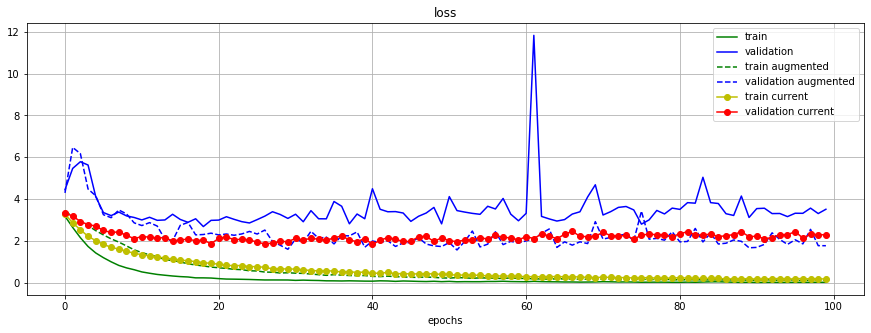

In [31]:
plt.figure(figsize=(15,5))
plt.plot(history_dict_unaugmented['loss'],'g-',label='train')
plt.plot(history_dict_unaugmented['val_loss'],'b-',label='validation')
plt.plot(history_dict_augmented['loss'],'g--',label='train augmented')
plt.plot(history_dict_augmented['val_loss'],'b--',label='validation augmented')
plt.plot(history_dict['loss'],'yo-',label='train current')
plt.plot(history_dict['val_loss'],'ro-',label='validation current')
plt.title('loss')
plt.xlabel('epochs')
plt.legend()
#plt.xticks(range(100),range(1,101))
plt.grid(True)

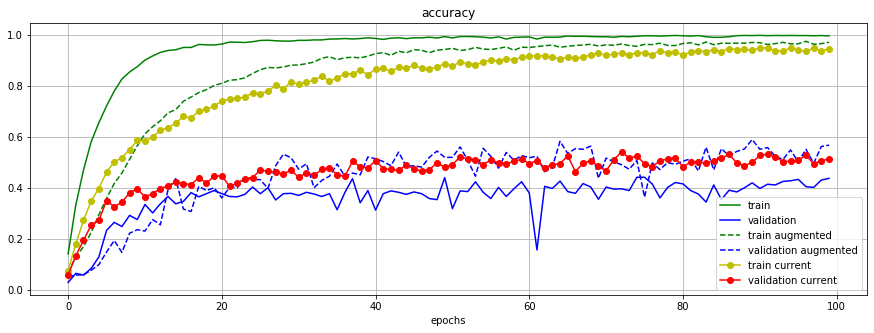

In [32]:
plt.figure(figsize=(15,5))
plt.plot(history_dict_unaugmented['accuracy'],'g-',label='train')
plt.plot(history_dict_unaugmented['val_accuracy'],'b-',label='validation')
plt.plot(history_dict_augmented['accuracy'],'g--',label='train augmented')
plt.plot(history_dict_augmented['val_accuracy'],'b--',label='validation augmented')
plt.plot(history_dict['accuracy'],'yo-',label='train current')
plt.plot(history_dict['val_accuracy'],'ro-',label='validation current')
plt.legend()
plt.xlabel('epochs')
plt.title('accuracy')
#plt.xticks(range(20),range(1,21))
plt.grid(True)

Text(0.5, 1.0, 'Val F1s in the last 20 epochs')

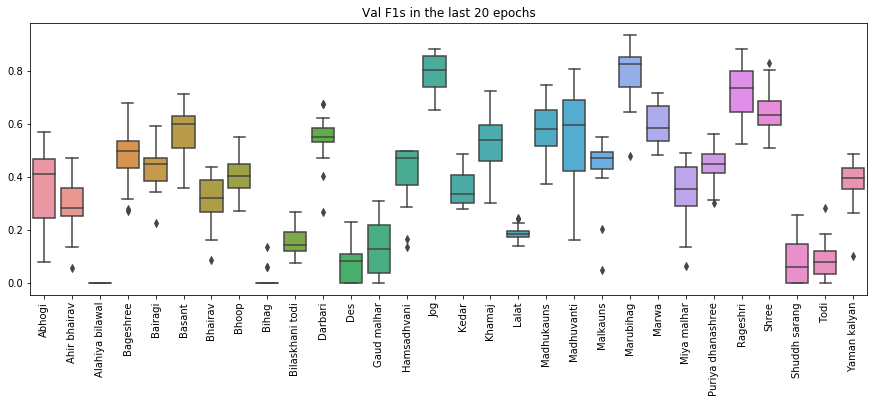

In [37]:
import pandas as pd
import seaborn as sns
fig=plt.figure(figsize=(15,5))
f1s=pd.DataFrame({ragas_reverse_idx[i]:history_dict_unaugmented['val_F1_{}'.format(i)][-20:] for i in range(30)})
ax=sns.boxplot( data=f1s)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Val F1s in the last 20 epochs')

Text(0.5, 1.0, 'Val F1s in the last 20 epochs')

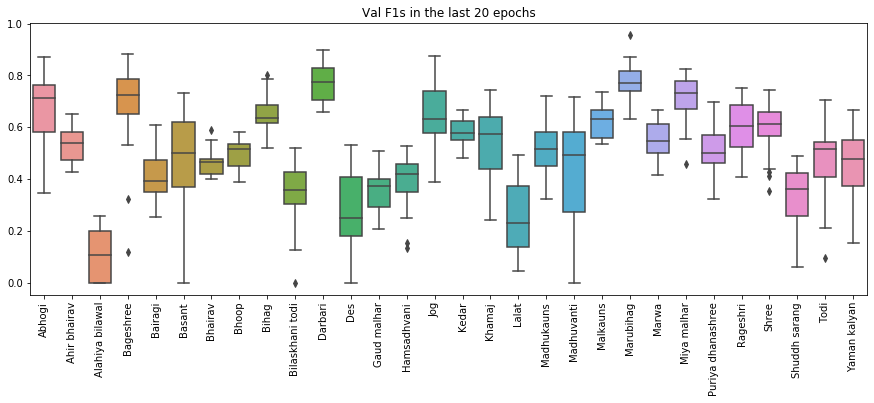

In [38]:
import pandas as pd
import seaborn as sns
fig=plt.figure(figsize=(15,5))
f1s=pd.DataFrame({ragas_reverse_idx[i]:history_dict_augmented['val_F1_{}'.format(i)][-20:] for i in range(30)})
ax=sns.boxplot( data=f1s)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Val F1s in the last 20 epochs')

Text(0.5, 1.0, 'Val F1s in the last 20 epochs')

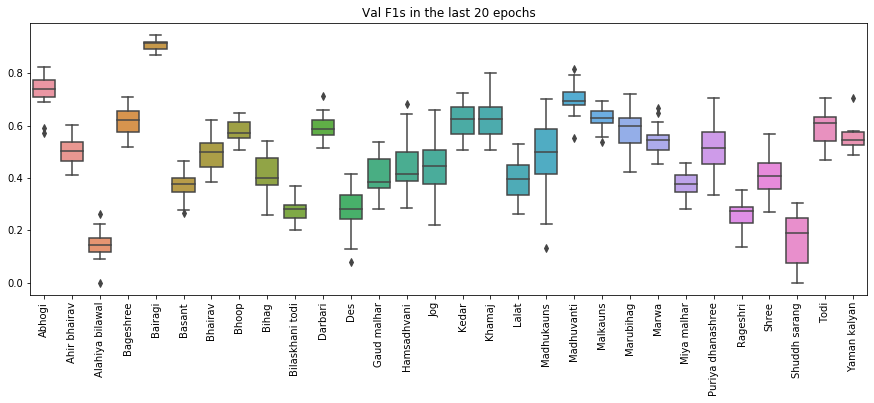

In [39]:
import pandas as pd
import seaborn as sns
fig=plt.figure(figsize=(15,5))
f1s=pd.DataFrame({ragas_reverse_idx[i]:history_dict['val_F1_{}'.format(i)][-20:] for i in range(30)})
ax=sns.boxplot( data=f1s)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Val F1s in the last 20 epochs')

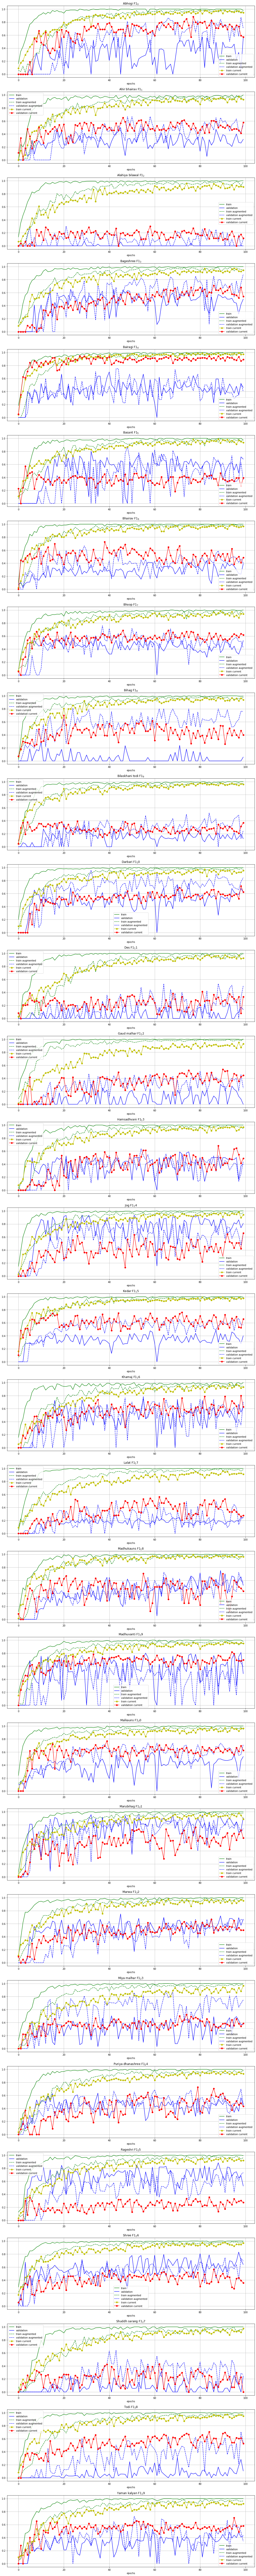

In [40]:
plt.figure(figsize=(15,5*30))
for i in range(30):
    plt.subplot(30,1,i+1)
    plt.plot(history_dict_unaugmented['F1_{}'.format(i)],'g-',label='train')
    plt.plot(history_dict_unaugmented['val_F1_{}'.format(i)],'b-',label='validation')
    plt.plot(history_dict_augmented['F1_{}'.format(i)],'g--',label='train augmented')
    plt.plot(history_dict_augmented['val_F1_{}'.format(i)],'b--',label='validation augmented')
    plt.plot(history_dict['F1_{}'.format(i)],'yo-',label='train current')
    plt.plot(history_dict['val_F1_{}'.format(i)],'ro-',label='validation current')
    plt.title(r'{raga_name} F1$_{raga_id}$'.format(raga_id=i,raga_name=ragas_reverse_idx[i]))
    plt.xlabel('epochs')
    plt.legend()
    #plt.xticks(range(20),range(1,21))
    plt.grid(True)
plt.tight_layout()

In [41]:
y_pred=np.argmax(model.predict(X_val),axis=-1)
y_true=y_val

In [42]:
cm=tf.math.confusion_matrix(y_true,y_pred,dtype=tf.float32,num_classes=30)


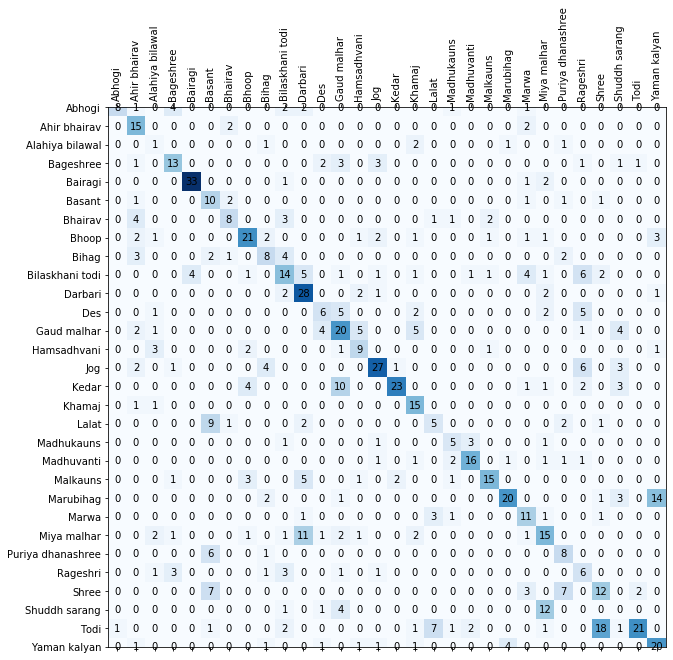

In [43]:
fig, ax = plt.subplots(figsize=(10,10))


cm_matrix = cm.numpy().astype(np.int32)

ax.matshow(cm_matrix, cmap=plt.cm.Blues)

for i in range(30):
    for j in range(30):
        c = cm_matrix[j,i]
        ax.text(i, j, str(c), va='center', ha='center',size=10)
plt.xticks(range(30),[ragas_reverse_idx[i] for i in range(30)],rotation=90)
plt.yticks(range(30),[ragas_reverse_idx[i] for i in range(30)],rotation=0)
plt.show()

In [47]:
def process_confusion_matrix(cm):
    "returns precision, recall and f1 along with overall accuracy"
    diag_part=tf.linalg.diag_part(cm)
    precision=diag_part/(tf.reduce_sum(cm,0)+tf.constant(1e-15))
    recall=diag_part/(tf.reduce_sum(cm,1)+tf.constant(1e-15))
    f1=2*precision*recall/(precision+recall+tf.constant(1e-15))
    return precision,recall,f1

In [48]:
precision,recall,f1=process_confusion_matrix(cm)

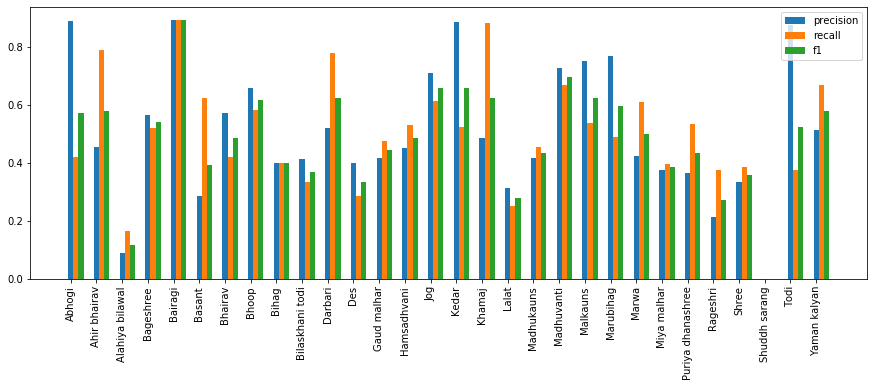

In [49]:
fig=plt.figure(figsize=(15,5))
plt.bar(np.arange(30),precision.numpy(),width=.2,label='precision')
plt.bar(np.arange(30)+.2,recall.numpy(),width=.2,label='recall')
plt.bar(np.arange(30)+.4,f1.numpy(),width=.2,label='f1')
plt.xticks(range(30),[ragas_reverse_idx[i] for i in range(30)],rotation=90)
plt.legend()
plt.show()